HEALTH_SCORE_

In [ ]:
# ----- columns you don't want in the final CSV -------------------------
cols_to_remove = [
    "NUMBEROFCORES", "ARMOURED", "NEUTRALMATERIAL", "CABLEID",
    "CABLECONDUCTORMATERIAL", "DIVISIONCODE", "ZONECODE",
    "FAULT_DIVISION",      # appears twice in your list―one name is enough
    "IR_Measurement_MOhm", "Tan_Delta",
    "Partial_Discharge_Frequency", "Partial_Discharge_Intensity",
    "SWITCH_NO"            # duplicate of SWITCH_ID in some master tables
]

cab = cab.drop(columns=[c for c in cols_to_remove if c in cab.columns])


In [ ]:
cab.to_csv(OUT_DIR/"cable_health_2024_scored.csv", index=False)


NameError: name 'cab' is not defined

Cell 1 — Poisson-LSTM forecasts (monthly / quarterly / yearly)

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Cell 1: Build fault history, train Poisson-LSTM, and save 2024 forecasts.
Outputs:
  OUT_DIR/per_switch_monthly_forecasts.csv
  OUT_DIR/per_switch_quarterly_forecasts.csv
  OUT_DIR/per_switch_yearly_forecasts.csv
"""

from __future__ import annotations
import logging, math, sys, json, numpy as np, pandas as pd
import torch, torch.nn as nn
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from warnings import filterwarnings
filterwarnings("ignore", category=FutureWarning)

# ─── paths ──────────────────────────────────────────────────────────────
FAULT_CSV = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/DATA_GENERATION/FAULT DATA/HT_fault_cable_info_processed_without_affected.csv")
CABLE_CSV = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/DATA_GENERATION/22_33KV CABLE FULL DATA/FINAL_22_33KV_TILL_SCADA.csv")
OUT_DIR   = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/A_fault_model_with_health")

# ─── constants / hyper-params ───────────────────────────────────────────
MIN_YEAR, TARGET_YEAR   = 2016, 2025
TRAIN_YEARS             = list(range(2018, TARGET_YEAR))
KEEP_VOLTAGES           = {22, 33}

BATCH, EPOCHS, PATIENCE = 64, 40, 12
LR, WD, CLIP            = 1e-3, 1e-5, 1.0
HID, LAY, DROP, EMB     = 256, 2, 0.1, 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42); np.random.seed(42)

logging.basicConfig(format="%(asctime)s | %(message)s",
                    datefmt="%H:%M:%S", level=logging.INFO, stream=sys.stdout)
log = logging.getLogger("pipeline").info

# ─── helper functions ───────────────────────────────────────────────────
def v_to_num(v):
    try: return float(str(v).lower().replace("kv",""))
    except: return math.nan

def norm_sw(s):
    return (s.astype(str).str.upper().str.strip()
             .str.replace(r"^(SWNO_|SWNO|SW|S)\s*", "", regex=True)
             .str.replace(r"\D+","",regex=True)
             .replace("", np.nan)).astype("Int64")

def month_range(a,b): return pd.period_range(f"{a}-01", f"{b}-12", freq="M")

def sincos(idx):
    ang = 2*np.pi*idx.month.values/12
    return np.stack([np.sin(ang), np.cos(ang)], 1)

def months_to_quarters(mat):
    q=np.zeros((mat.shape[0],4))
    q[:,0]=mat[:,0:3].sum(1); q[:,1]=mat[:,3:6].sum(1)
    q[:,2]=mat[:,6:9].sum(1); q[:,3]=mat[:,9:12].sum(1)
    return q

# ─── 1 · fault history ──────────────────────────────────────────────────
fault=pd.read_csv(FAULT_CSV,parse_dates=["TIME_OUTAGE"],low_memory=False)
sw_col="TO_SWITCH" if "TO_SWITCH" in fault.columns else fault.columns[0]
fault["SWITCH_ID"]=norm_sw(fault[sw_col])
fault=fault.dropna(subset=["SWITCH_ID","TIME_OUTAGE"])
fault=fault[fault["TIME_OUTAGE"].dt.year.between(MIN_YEAR,TARGET_YEAR)]
if "VOLTAGE" in fault.columns:
    fault["VNUM"]=fault["VOLTAGE"].apply(v_to_num)
    fault=fault[fault["VNUM"].isin(KEEP_VOLTAGES)]
fault=fault.drop_duplicates(["SWITCH_ID","TIME_OUTAGE"])
fault["YM"]=fault["TIME_OUTAGE"].dt.to_period("M")

idx_full=month_range(MIN_YEAR,TARGET_YEAR)
counts=(fault[fault["TIME_OUTAGE"].dt.year<=TARGET_YEAR-1]
        .groupby(["SWITCH_ID","YM"]).size()
        .unstack(fill_value=0)
        .reindex(columns=idx_full,fill_value=0).astype(float))
switches=counts.index.tolist(); sw2idx={sw:i for i,sw in enumerate(switches)}

# ─── 2 · Poisson-LSTM dataset & training ────────────────────────────────
class WinDS(Dataset):
    def __init__(self, fr):
        self.x  = torch.tensor(fr["X_seq"],dtype=torch.float32)
        self.xs = torch.tensor(fr["X_season"],dtype=torch.float32)
        self.y  = torch.tensor(fr["y_seq"],dtype=torch.float32)
        self.sw = torch.tensor(fr["sw_idx"],dtype=torch.long)
    def __len__(self): return len(self.sw)
    def __getitem__(self,i): return self.x[i],self.xs[i],self.y[i],self.sw[i]

class PoissonLSTM(nn.Module):
    def __init__(self,n_sw):
        super().__init__()
        self.emb = nn.Embedding(n_sw, EMB)
        self.rnn = nn.LSTM(3,HID,LAY,batch_first=True,
                           dropout=DROP if LAY>1 else 0.)
        self.head=nn.Sequential(nn.Linear(HID+EMB,HID),nn.ReLU(),
                                nn.Linear(HID,HID//2),nn.ReLU(),
                                nn.Linear(HID//2,12))
        self.sp = nn.Softplus()
    def forward(self,x,xs,sw):
        h,_=self.rnn(torch.cat([x,xs],-1))
        h=torch.cat([h[:,-1],self.emb(sw)],1)
        return self.sp(self.head(h))

def build_frames(years, nonzero=True):
    X_seq,X_sea,y_seq,sw_idx=[],[],[],[]
    for sw,row in counts.iterrows():
        for Y in years:
            tr,tg=month_range(Y-2,Y-1),month_range(Y,Y)
            if nonzero and row[tr].sum()==0: continue
            X_seq.append(np.log1p(row[tr]).values[:,None])
            X_sea.append(sincos(tr)); y_seq.append(row[tg].values)
            sw_idx.append(sw2idx[sw])
    return dict(X_seq=np.stack(X_seq),
                X_season=np.stack(X_sea),
                y_seq=np.stack(y_seq),
                sw_idx=np.array(sw_idx,dtype=np.int64))

train_frames=build_frames(TRAIN_YEARS,True)
ds=WinDS(train_frames); perm=np.random.permutation(len(ds))
n_val=max(1,int(.1*len(ds)))
dl_tr=DataLoader(torch.utils.data.Subset(ds,perm[:-n_val]),BATCH,shuffle=True)
dl_va=DataLoader(torch.utils.data.Subset(ds,perm[-n_val:]),BATCH,shuffle=False)

model=PoissonLSTM(len(switches)).to(DEVICE)
loss_fn,opt=nn.PoissonNLLLoss(log_input=False),torch.optim.Adam(model.parameters(),lr=LR,weight_decay=WD)

best,bad,best_ep=1e9,0,0
for ep in range(1,EPOCHS+1):
    model.train()
    for xb,xs,yb,swb in dl_tr:
        xb,xs,yb,swb=[t.to(DEVICE) for t in (xb,xs,yb,swb)]
        opt.zero_grad(); loss_fn(model(xb,xs,swb),yb).backward()
        nn.utils.clip_grad_norm_(model.parameters(),CLIP); opt.step()
    with torch.no_grad():
        v=np.mean([loss_fn(model(x.to(DEVICE),xs.to(DEVICE),sw.to(DEVICE)),
                           y.to(DEVICE)).item()
                   for x,xs,y,sw in dl_va])
    if v<best-1e-4: best,bad,best_ep,ckpt=v,0,ep,model.state_dict()
    else: bad+=1
    if bad>=PATIENCE: break
model.load_state_dict(ckpt)
log(f"Training finished in {best_ep} epochs | best val-loss={best:.4f}")

# ─── 3 · 2024 forecasts & save CSVs ─────────────────────────────────────
def months_to_quarters(mat):
    q=np.zeros((mat.shape[0],4))
    q[:,0]=mat[:,0:3].sum(1); q[:,1]=mat[:,3:6].sum(1)
    q[:,2]=mat[:,6:9].sum(1); q[:,3]=mat[:,9:12].sum(1)
    return q

eval_frames=build_frames([TARGET_YEAR],False)
mu,swids=[],[]
with torch.no_grad():
    for xb,xs,_,swb in DataLoader(WinDS(eval_frames),256,False):
        xb,xs,swb=[t.to(DEVICE) for t in (xb,xs,swb)]
        mu.append(model(xb,xs,swb).cpu().numpy())
        swids.append(swb.cpu().numpy())
MU,SWIDX=np.concatenate(mu),np.concatenate(swids)
QTRS=months_to_quarters(MU)

ym=month_range(TARGET_YEAR,TARGET_YEAR)
rows_m,rows_q,rows_y=[],[],[]
for i,ix in enumerate(SWIDX):
    sw=switches[ix]
    rows_y.append(dict(SWITCH_ID=sw,YEAR=TARGET_YEAR,PRED_FULL=float(MU[i].sum())))
    for m in range(12):
        rows_m.append(dict(SWITCH_ID=sw,YEAR=TARGET_YEAR,MONTH=m+1,
                           YM=str(ym[m]),PRED_FAULTS=float(MU[i,m])))
    for qi,qsum in enumerate(QTRS[i],1):
        rows_q.append(dict(SWITCH_ID=sw,YEAR=TARGET_YEAR,QUARTER=qi,
                           PRED_FAULTS_Q=float(qsum)))

OUT_DIR.mkdir(parents=True,exist_ok=True)
pd.DataFrame(rows_m).to_csv(OUT_DIR/"per_switch_monthly_forecasts.csv",index=False)
pd.DataFrame(rows_q).to_csv(OUT_DIR/"per_switch_quarterly_forecasts.csv",index=False)
pd.DataFrame(rows_y).to_csv(OUT_DIR/"per_switch_yearly_forecasts.csv",index=False)
log("Saved 2024 forecasts → %s", OUT_DIR.resolve())



/tmp/ipykernel_22286/1462079397.py:72: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  fault["YM"]=fault["TIME_OUTAGE"].dt.to_period("M")


10:38:22 | Training finished in 15 epochs | best val-loss=0.2452
10:38:22 | Saved 2024 forecasts → /media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/A_fault_model_with_health


In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Cell 2: Compute 9-factor health scores, print fleet-wide summary,
and validate against 2024 actual faults.
Reads forecasts saved by Cell 1.
Outputs:
  OUT_DIR/cable_health_2024_scored.csv
  OUT_DIR/cable_health_2024_predictions.csv
"""

from __future__ import annotations
import logging, math, sys, json, numpy as np, pandas as pd
from pathlib import Path
from warnings import filterwarnings
from datetime import date
from sklearn.metrics import confusion_matrix, roc_auc_score
filterwarnings("ignore", category=FutureWarning)

# ─── paths (same as Cell 1) ─────────────────────────────────────────────
FAULT_CSV = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/DATA_GENERATION/FAULT DATA/HT_fault_cable_info_processed_without_affected.csv")
CABLE_CSV = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/DATA_GENERATION/22_33KV CABLE FULL DATA/FINAL_22_33KV_TILL_SCADA.csv")
OUT_DIR   = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/A_fault_model_with_health")

# ─── constants ──────────────────────────────────────────────────────────
MIN_YEAR, TARGET_YEAR   = 2016, 2025
KEEP_VOLTAGES           = {22, 33}
EXPECTED_LIFE_YEARS     = 35


# 9-factor weights — AEML POV
# p stays fixed at 0.15; remaining 0.85 distributed by AEML rank order
W = dict(
    l=0.25,  # 1) Length (ℓ)
    s=0.21,  # 2) Segments (s)
    f=0.12,  # 3) Faults/km (f)
    r=0.11,  # 4) Load-range utilisation (r)
    a=0.06,  # 5) Age (a)
    i=0.05,  # 6) Interruption frequency (i)
    c=0.03,  # 7) Cyclic loading (c)
    u=0.02,  # 8) Recent-8-month faults (u)
    p=0.15   # (fixed) Predicted faults (ML) (p)
)

# W = dict(
#     l= 0.22,
#     u= 0.20,
#     f= 0.12,
#     i= 0.12,
#     s= 0.08,
#     r= 0.06,
#     c= 0.05,
#     a= 0.00,
#     p= 0.15
# )


logging.basicConfig(format="%(asctime)s | %(message)s",
                    datefmt="%H:%M:%S", level=logging.INFO, stream=sys.stdout)
log = logging.getLogger("pipeline").info

# ─── helpers used here ──────────────────────────────────────────────────
def v_to_num(v):
    try: return float(str(v).lower().replace("kv",""))
    except: return math.nan

def norm_sw(s):
    return (s.astype(str).str.upper().str.strip()
             .str.replace(r"^(SWNO_|SWNO|SW|S)\s*", "", regex=True)
             .str.replace(r"\D+","",regex=True)
             .replace("", np.nan)).astype("Int64")

def robust(s, lo=5, hi=95):
    c=s.replace([np.inf,-np.inf],np.nan).dropna()
    if c.empty: return pd.Series(0., index=s.index)
    a,b=np.percentile(c,[lo,hi]); return ((s-a).clip(0,b-a)/(b-a+1e-9)).fillna(0.)

# ─── load forecasts & raw data ──────────────────────────────────────────
per_y = pd.read_csv(OUT_DIR/"per_switch_yearly_forecasts.csv")
fault = pd.read_csv(FAULT_CSV, parse_dates=["TIME_OUTAGE"], low_memory=False)
sw_col="TO_SWITCH" if "TO_SWITCH" in fault.columns else fault.columns[0]
fault["SWITCH_ID"]=norm_sw(fault[sw_col])
fault=fault.dropna(subset=["SWITCH_ID","TIME_OUTAGE"])
fault=fault[fault["TIME_OUTAGE"].dt.year.between(MIN_YEAR,TARGET_YEAR)]
if "VOLTAGE" in fault.columns:
    fault["VNUM"]=fault["VOLTAGE"].apply(v_to_num)
    fault=fault[fault["VNUM"].isin(KEEP_VOLTAGES)]
fault=fault.drop_duplicates(["SWITCH_ID","TIME_OUTAGE"])

cables=pd.read_csv(CABLE_CSV, low_memory=False).drop_duplicates("DESTINATION_SWITCH_ID")

# ─── 4 · health score (9 factors) ───────────────────────────────────────
cab=cables.rename(columns={"DESTINATION_SWITCH_ID":"SWITCH_ID",
                           "MEASUREDLENGTH":"LENGTH_M",
                           "COMMISSIONEDDATE":"DATE_INSTALLED",
                           "NO_OF_SEGMENT":"SEGMENTS"})
cab["LENGTH_KM"]=pd.to_numeric(cab["LENGTH_M"],errors="coerce")/1000
cab["DATE_INSTALLED"]=(pd.to_datetime(cab["DATE_INSTALLED"],errors="coerce",utc=True)
                       .dt.tz_localize(None))

# SCADA-derived features if present
cyc=[c for c in cab.columns if c.startswith("CYCLE_Month_")]
var=[c for c in cab.columns if c.startswith("VAR_Month_")]
cab["cycle_pm"]=cab[cyc].mean(1) if len(cyc) else np.nan
cab["load_range_idx"]=(cab[var].mean(1)/cab[var].median(1)) if len(var) else np.nan

# historic faults (till 2023)
hist=fault[fault["TIME_OUTAGE"].dt.year<=TARGET_YEAR-1].groupby("SWITCH_ID").size()
cab=cab.merge(hist.rename("hist_faults"),on="SWITCH_ID",how="left").fillna({"hist_faults":0})

# predicted faults 2024 from Cell 1 CSV
cab=cab.merge(per_y.rename(columns={"PRED_FULL":"pred_faults_2024"}),
              on="SWITCH_ID",how="left").fillna({"pred_faults_2024":0})

# mean inter-fault hours
fault_naive = fault.copy()
fault_naive["TIME_OUTAGE"] = fault_naive["TIME_OUTAGE"].dt.tz_localize(None)

fault_pre2025 = fault_naive[fault_naive["TIME_OUTAGE"] < pd.Timestamp("2025-01-01")].copy()


# ── 2)  Within each switch, sort chronologically and compute Δt_h (hours) ────
fault_sorted = fault_pre2025.sort_values(["SWITCH_ID", "TIME_OUTAGE"])

fault_sorted["Δt_h"] = (
    fault_sorted.groupby("SWITCH_ID")["TIME_OUTAGE"]
    .diff()                               # timedeltas between successive rows
    .dt.total_seconds() / (3600*24)            # convert seconds → hours
)

# ── 3)  Get the mean interval per switch ─────────────────────────────────────
mean_dt = (
    fault_sorted.groupby("SWITCH_ID")["Δt_h"]
    .mean()
    .rename("mean_d")
)

# ── 4)  Merge the mean into your cable table (cab) ───────────────────────────
cab = cab.merge(mean_dt, on="SWITCH_ID", how="left")


# recent 8-month window count (relative to Jan 1, 2024)
recent_cut=(pd.Timestamp(f"{TARGET_YEAR}-01-01", tz="UTC") - pd.DateOffset(months=8))
recent_cnt=(fault[fault["TIME_OUTAGE"]>=recent_cut].groupby("SWITCH_ID").size())
cab=cab.merge(recent_cnt.rename("recent8"),on="SWITCH_ID",how="left").fillna({"recent8":0})

# age fraction of expected life
cab["DATE_INSTALLED"] = pd.to_datetime(cab["DATE_INSTALLED"])
today = pd.Timestamp(date.today())
time_elapsed = today - cab["DATE_INSTALLED"]
days_elapsed = time_elapsed.dt.days
expected_total_days = EXPECTED_LIFE_YEARS * 365
cab["a_raw"] = days_elapsed / expected_total_days

# raw factors
cab["c_raw"]=cab["cycle_pm"]
cab["r_raw"]=cab["load_range_idx"]
cab["f_raw"]=cab["hist_faults"]/cab["LENGTH_KM"].replace(0,np.nan)
cab["s_raw"]=(cab["SEGMENTS"].fillna(1)).clip(lower=0)
cab["p_raw"]=cab["pred_faults_2024"].replace(0,np.nan)
cab["i_raw"]=1/cab["mean_d"].clip(lower=1)
cab["l_raw"]=np.log1p(cab["LENGTH_KM"])    # length factor
cab["u_raw"]=cab["recent8"]

# scale to 0-1 using robust percentiles
for col in ["c_raw","r_raw","a_raw","f_raw","s_raw","p_raw","i_raw","l_raw","u_raw"]:
    cab[col[0]]=robust(cab[col])

# risk & score
risk=sum(W[k]*cab[k] for k in W.keys())
cab["health_score"]=np.rint(100*(1-risk)).clip(0,100).astype(int)
cab["health_score_10"]=np.clip(np.ceil(cab["health_score"]/10),1,10).astype(int)
cab["health_band"]=pd.cut(cab["health_score"],[-np.inf,40,60,100],
                          labels=["Poor","Moderate","Good"])

# driver labels
LABELS = {
    "c":"High cyclic loading (c)",
    "r":"Wide load-range utilisation (r)",
    "a":"Advanced cable age (a)",
    "f":"Many historic faults (f)",
    "s":"Numerous joints / segments (s)",
    "p":"High predicted faults per km (p)",
    "i":"Frequent interruptions (i)",
    "l":"Long circuit length (ℓ)",
    "u":"Recent-8-month faults(u)"
}
risk_contrib=pd.DataFrame({k:W[k]*cab[k] for k in W.keys()})
top3=risk_contrib.apply(lambda r:r.nlargest(3).index.tolist(),axis=1)
cab["primary_health_driver"]=top3.apply(lambda lst: LABELS[lst[0]])
cab["top3_health_drivers"]=top3.apply(lambda lst: "; ".join(LABELS[k] for k in lst))

# Set perfect health where no faults ever
mask_nofault=(cab["hist_faults"].eq(0)&cab["recent8"].eq(0))
cab.loc[mask_nofault,["health_score","health_score_10"]]=[100,10]
cab.loc[mask_nofault,"health_band"]="Good"
cab.loc[mask_nofault,"primary_health_driver"]="No recorded faults"
cab.loc[mask_nofault,"top3_health_drivers"]="No recorded faults"

# save CSVs
OUT_DIR.mkdir(parents=True,exist_ok=True)
cab.to_csv(OUT_DIR/"cable_health_2025_scored_acc_client_ranking.csv",index=False)
cab_pred=cab[~mask_nofault]
cab_pred.to_csv(OUT_DIR/"cable_health_2025_predictions.csv",index=False)
log(f"Saved predictions for {len(cab_pred)} cables -> cable_health_2025_predictions.csv")

# ─── fleet-wide summary ─────────────────────────────────────────────────
total_predicted_faults = per_y['PRED_FULL'].sum()
total_actual_faults_2024 = fault[fault['TIME_OUTAGE'].dt.year == TARGET_YEAR].shape[0]

log("\n" + "="*40)
log(f"FLEET-WIDE FAULT SUMMARY FOR YEAR {TARGET_YEAR}")
log("="*40)
log(f"Total Predicted Faults: {total_predicted_faults:.1f}")
log(f"Total Actual Faults:    {total_actual_faults_2024}")
log("="*40 + "\n")

# ─── validation ─────────────────────────────────────────────────────────
actual=fault[fault["TIME_OUTAGE"].dt.year==TARGET_YEAR]["SWITCH_ID"].unique()
cab["ACTUAL_FAIL_24"]=cab["SWITCH_ID"].isin(actual).astype(int)
pred=cab["health_band"].map({"Poor":1,"Moderate":1,"Good":0})
cm=confusion_matrix(cab["ACTUAL_FAIL_24"],pred)
au=roc_auc_score(cab["ACTUAL_FAIL_24"],100-cab["health_score"])
log(f"2024 confusion matrix:\n{cm}\nAUROC = {au:.3f}")
log("Factor weights applied: "+json.dumps(W))
log("Pipeline complete → %s", OUT_DIR.resolve())


17:43:56 | Saved predictions for 190 cables -> cable_health_2025_predictions.csv
17:43:56 | 
17:43:56 | FLEET-WIDE FAULT SUMMARY FOR YEAR 2025
17:43:56 | ========================================
17:43:56 | Total Predicted Faults: 148.4
17:43:56 | Total Actual Faults:    26
17:43:56 | ========================================

17:43:56 | 2024 confusion matrix:
[[146  89]
 [  7  14]]
AUROC = 0.711
17:43:56 | Factor weights applied: {"l": 0.25, "s": 0.21, "f": 0.12, "r": 0.11, "a": 0.06, "i": 0.05, "c": 0.03, "u": 0.02, "p": 0.15}
17:43:56 | Pipeline complete → /media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/A_fault_model_with_health


In [22]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Cell 2: Compute 10-factor health scores (adds recovery time),
print fleet-wide summary, and validate against 2024 actual faults.
Reads forecasts saved by Cell 1.
Outputs:
  OUT_DIR/cable_health_2024_scored.csv
  OUT_DIR/cable_health_2024_predictions.csv
"""

from __future__ import annotations
import logging, math, sys, json, numpy as np, pandas as pd
from pathlib import Path
from warnings import filterwarnings
from datetime import date
from sklearn.metrics import confusion_matrix, roc_auc_score
filterwarnings("ignore", category=FutureWarning)

# ─── paths (same as Cell 1) ─────────────────────────────────────────────
FAULT_CSV = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/DATA_GENERATION/FAULT DATA/HT_fault_cable_info_processed_final.csv")
CABLE_CSV = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/DATA_GENERATION/22_33KV CABLE FULL DATA/FINAL_22_33KV_TILL_SCADA.csv")
OUT_DIR   = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/A_fault_model_with_health")

# ─── constants ──────────────────────────────────────────────────────────
MIN_YEAR, TARGET_YEAR   = 2016, 2024
KEEP_VOLTAGES           = {22, 33}
EXPECTED_LIFE_YEARS     = 35

# ─── 10-factor weights (adds recovery time as “d”) ───────────────────────
# W = {
#     "l": 0.2207,  # length
#     "u": 0.2000,  # recent-8m faults
#     "f": 0.1229,  # historic faults/km
#     "i": 0.1174,  # inter-arrival frequency
#     "s": 0.0782,  # segments
#     "r": 0.0588,  # load-range
#     "c": 0.0500,  # cyclic loading
#     "a": 0.0021,  # age
#     "p": 0.1500,  # predicted faults
#     "d": 0.0500,  # *new* recovery duration
# }


#BEST W TILL NOW
W={
  "l": 0.23,
  "u": 0.20,
  "p": 0.15,
  "f": 0.10,
  "i": 0.09,
  "d": 0.06,
  "s": 0.05,
  "r": 0.05,
  "c": 0.04,
  "a": 0.03
}

   





logging.basicConfig(format="%(asctime)s | %(message)s",
                    datefmt="%H:%M:%S", level=logging.INFO, stream=sys.stdout)
log = logging.getLogger("pipeline").info

# ─── helpers ─────────────────────────────────────────────────────────────
def v_to_num(v):
    try: return float(str(v).lower().replace("kv",""))
    except: return math.nan

def norm_sw(s):
    return (s.astype(str).str.upper().str.strip()
            .str.replace(r"^(SWNO_|SWNO|SW|S)\s*", "", regex=True)
            .str.replace(r"\D+","",regex=True)
            .replace("", np.nan)).astype("Int64")

def robust(s, lo=5, hi=95):
    c = s.replace([np.inf,-np.inf],np.nan).dropna()
    if c.empty: return pd.Series(0., index=s.index)
    a,b = np.percentile(c,[lo,hi])
    return ((s-a).clip(0,b-a)/(b-a+1e-9)).fillna(0.)

# ─── load forecasts & raw data ──────────────────────────────────────────
per_y = pd.read_csv(OUT_DIR/"per_switch_yearly_forecasts.csv")
fault = pd.read_csv(FAULT_CSV, parse_dates=["TIME_OUTAGE"], low_memory=False)

# normalize switch ID and filter
sw_col = "TO_SWITCH" if "TO_SWITCH" in fault.columns else fault.columns[0]
fault["SWITCH_ID"] = norm_sw(fault[sw_col])
fault = fault.dropna(subset=["SWITCH_ID","TIME_OUTAGE","TIME_DIFFERENCE_HOURS"])
fault = fault[fault["TIME_OUTAGE"].dt.year.between(MIN_YEAR, TARGET_YEAR)]
if "VOLTAGE" in fault.columns:
    fault["VNUM"] = fault["VOLTAGE"].apply(v_to_num)
    fault = fault[fault["VNUM"].isin(KEEP_VOLTAGES)]
fault = fault.drop_duplicates(["SWITCH_ID","TIME_OUTAGE"])

cables = pd.read_csv(CABLE_CSV, low_memory=False).drop_duplicates("DESTINATION_SWITCH_ID")

# ─── 4 · health score (10 factors) ───────────────────────────────────────
cab = cables.rename(columns={
    "DESTINATION_SWITCH_ID":"SWITCH_ID",
    "MEASUREDLENGTH":"LENGTH_M",
    "COMMISSIONEDDATE":"DATE_INSTALLED",
    "NO_OF_SEGMENT":"SEGMENTS"
})
cab["LENGTH_KM"] = pd.to_numeric(cab["LENGTH_M"], errors="coerce")/1000
cab["DATE_INSTALLED"] = (
    pd.to_datetime(cab["DATE_INSTALLED"], errors="coerce", utc=True)
      .dt.tz_localize(None)
)

# SCADA features if present
cyc = [c for c in cab.columns if c.startswith("CYCLE_Month_")]
var = [c for c in cab.columns if c.startswith("VAR_Month_")]
cab["cycle_pm"]      = cab[cyc].mean(axis=1) if cyc else np.nan
cab["load_range_idx"] = (cab[var].mean(axis=1)/cab[var].median(axis=1)) if var else np.nan

# historic & predicted faults
hist = fault[fault["TIME_OUTAGE"].dt.year <= TARGET_YEAR-1] \
       .groupby("SWITCH_ID").size().rename("hist_faults")
cab = cab.merge(hist, on="SWITCH_ID", how="left").fillna({"hist_faults":0})

cab = cab.merge(
    per_y.rename(columns={"PRED_FULL":"pred_faults_2024"}),
    on="SWITCH_ID", how="left"
).fillna({"pred_faults_2024":0})

# mean inter-fault hours
fault_sorted = fault.sort_values(["SWITCH_ID","TIME_OUTAGE"])
fault_sorted["Δt_h"] = (
    fault_sorted.groupby("SWITCH_ID")["TIME_OUTAGE"]
                .diff().dt.total_seconds().div(3600)
)
mean_dt = fault_sorted.groupby("SWITCH_ID")["Δt_h"].mean().rename("mean_h")
cab = cab.merge(mean_dt, on="SWITCH_ID", how="left")

# recent 8-month faults
recent_cut = pd.Timestamp(f"{TARGET_YEAR}-01-01", tz="UTC") - pd.DateOffset(months=8)
recent8 = fault[fault["TIME_OUTAGE"] >= recent_cut]\
           .groupby("SWITCH_ID").size().rename("recent8")
cab = cab.merge(recent8, on="SWITCH_ID", how="left").fillna({"recent8":0})

# compute recovery duration per outage and then average across outages
# (we already have TIME_DIFFERENCE_HOURS parsed above)
   # reuse the prebuilt TIME_DIFFERENCE_HOURS (in hours) as the recovery duration:
# NEW:
import pandas as pd

def compute_mean_recovery(fault: pd.DataFrame) -> pd.Series:
    """
    Given a fault DataFrame with columns
      - 'SWITCH_ID'
      - 'TIME_DIFFERENCE_HOURS' (outage→restored in hours, but possibly object dtype)
    returns a pd.Series indexed by SWITCH_ID named 'mean_recovery_h'
    containing the average recovery time in hours.
    """
    # Work on a copy so we don't clobber the original
    df = fault.copy()
    
    # 1) Ensure we have a float duration column
    df["recovery_h"] = pd.to_numeric(df["TIME_DIFFERENCE_HOURS"], errors="coerce")
    
    # 2) Group and take the mean (numeric_only to skip any non-numeric silently)
    mean_recovery = (
        df
        .groupby("SWITCH_ID")["recovery_h"]
        .mean(numeric_only=True)
        .rename("mean_recovery_h")
    )
    
    return mean_recovery

mean_recovery = compute_mean_recovery(fault)
cab = cab.merge(mean_recovery, on="SWITCH_ID", how="left")



# age fraction
today = pd.Timestamp(date.today())
elapsed = (today - cab["DATE_INSTALLED"]).dt.days
cab["a_raw"] = elapsed / (EXPECTED_LIFE_YEARS * 365)

# raw factors (first letter keys)
cab["c_raw"] = cab["cycle_pm"]
cab["r_raw"] = cab["load_range_idx"]
cab["f_raw"] = cab["hist_faults"] / cab["LENGTH_KM"].replace(0,np.nan)
cab["s_raw"] = cab["SEGMENTS"].fillna(0)
cab["p_raw"] = cab["pred_faults_2024"].replace(0,np.nan)
cab["i_raw"] = 1 / cab["mean_h"].clip(lower=1)
cab["l_raw"] = np.log1p(cab["LENGTH_KM"])
cab["u_raw"] = cab["recent8"]
# ─── new recovery factor “d” ─────────────────────────────
cab["d_raw"] = cab["mean_recovery_h"].clip(lower=1)

# robust scaling to [0,1]
for col in ["c_raw","r_raw","a_raw","f_raw","s_raw","p_raw","i_raw","l_raw","u_raw","d_raw"]:
    key = col[0]
    cab[key] = robust(cab[col])

# combine into risk & score
risk = sum(W[k] * cab[k] for k in W)
cab["health_score"]   = np.rint(100 * (1 - risk)).clip(0,100).astype(int)
cab["health_score_10"]= np.clip(np.ceil(cab["health_score"]/10),1,10).astype(int)
cab["health_band"]    = pd.cut(
    cab["health_score"], bins=[-np.inf,40,60,100],
    labels=["Poor","Moderate","Good"]
)

# identify top-3 drivers
LABELS = {
    "c":"High cyclic loading (c)",
    "r":"Wide load-range (r)",
    "a":"Advanced age (a)",
    "f":"Many historic faults (f)",
    "s":"Numerous segments (s)",
    "p":"High predicted faults (p)",
    "i":"Frequent interruptions (i)",
    "l":"Long length (ℓ)",
    "u":"Recent-8m faults (u)",
    "d":"Slow recovery time (d)",
}
risk_contrib = pd.DataFrame({k: W[k]*cab[k] for k in W})
top3 = risk_contrib.apply(lambda r: r.nlargest(3).index.tolist(), axis=1)
cab["primary_health_driver"]  = top3.apply(lambda lst: LABELS[lst[0]])
cab["top3_health_drivers"]    = top3.apply(lambda lst: "; ".join(LABELS[k] for k in lst))

# perfect-health override
mask_no_fault = (cab["hist_faults"].eq(0) & cab["recent8"].eq(0))
cab.loc[mask_no_fault, ["health_score","health_score_10"]] = [100,10]
cab.loc[mask_no_fault, "health_band"]           = "Good"
cab.loc[mask_no_fault, "primary_health_driver"] = "No recorded faults"
cab.loc[mask_no_fault, "top3_health_drivers"]   = "No recorded faults"

# save
OUT_DIR.mkdir(parents=True, exist_ok=True)
cab.to_csv(OUT_DIR/"cable_health_2024_scored.csv", index=False)
cab_pred = cab[~mask_no_fault]
cab_pred.to_csv(OUT_DIR/"cable_health_2024_predictions.csv", index=False)
log(f"Saved predictions for {len(cab_pred)} cables → cable_health_2024_predictions.csv")

# ─── summary & validation ─────────────────────────────────────────────────
total_pred = per_y["PRED_FULL"].sum()
actual_cnt = fault[fault["TIME_OUTAGE"].dt.year == TARGET_YEAR].shape[0]
log("\n" + "="*30)
log(f"FLEET SUMMARY {TARGET_YEAR}")
log("="*30)
log(f"Predicted faults: {total_pred:.1f}")
log(f"Actual faults:    {actual_cnt}")
log("="*30 + "\n")

cab["ACTUAL_FAIL_24"] = cab["SWITCH_ID"].isin(
    fault[fault["TIME_OUTAGE"].dt.year==TARGET_YEAR]["SWITCH_ID"]
).astype(int)
pred = cab["health_band"].map({"Poor":1,"Moderate":1,"Good":0})
cm, au = confusion_matrix(cab["ACTUAL_FAIL_24"], pred), roc_auc_score(cab["ACTUAL_FAIL_24"], 100-cab["health_score"])
log(f"Confusion matrix:\n{cm}\nAUROC = {au:.3f}")
log(f"Factor weights: {json.dumps(W)}")
log(f"Pipeline complete → {OUT_DIR.resolve()}")


17:29:16 | Saved predictions for 190 cables → cable_health_2024_predictions.csv
17:29:16 | 
17:29:16 | FLEET SUMMARY 2024
17:29:16 | ==============================
17:29:16 | Predicted faults: 124.6
17:29:16 | Actual faults:    128
17:29:16 | ==============================

17:29:16 | Confusion matrix:
[[158  26]
 [ 15  57]]
AUROC = 0.883
17:29:16 | Factor weights: {"l": 0.23, "u": 0.2, "p": 0.15, "f": 0.1, "i": 0.09, "d": 0.06, "s": 0.05, "r": 0.05, "c": 0.04, "a": 0.03}
17:29:16 | Pipeline complete → /media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/A_fault_model_with_health


In [16]:
import numpy as np
import pandas as pd
import json
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, confusion_matrix

# ─── Your factor ranking & fixed parameters ────────────────────────────────
RANK_DESC = ["l","u","f","d","r","a","s","i","c"]  # non-p factors, now with 'd'
FIX_P    = 0.15   # hold p at 15%
CAP_U    = 0.15   # optionally cap u at 10%

# ─── Helpers ────────────────────────────────────────────────────────────────
def _eval_preds(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    tn, fp, fn, tp = cm.ravel()
    acc = (tn + tp) / cm.sum()
    spec = tn / (tn + fp) if (tn + fp) else 0.0
    return dict(TN=int(tn), FP=int(fp), FN=int(fn), TP=int(tp),
                Acc=acc, Prec=prec, Rec=rec, F1=f1, Spec=spec)

def _best_threshold_metrics(risk_vec, y_true,
                            metric="F1", prec_floor=0.50):
    # Sweep thresholds on risk to get best F1 or recall@precision
    grid = np.round(np.arange(0.10, 0.70, 0.01), 2)
    rows = []
    for thr in grid:
        y_pred = (risk_vec >= thr).astype(int)
        m = _eval_preds(y_true, y_pred)
        m.update(thr=float(thr), Pos=int(y_pred.sum()))
        rows.append(m)
    df = pd.DataFrame(rows)

    if metric.upper() == "F1":
        return df.sort_values("F1", ascending=False).iloc[0].to_dict()
    elif metric.upper() == "RECALL_AT_PREC":
        cand = df[df["Prec"] >= prec_floor] \
                .sort_values(["Rec","F1"], ascending=[False,False])
        if len(cand):
            best = cand.iloc[0].to_dict()
            best["metric_note"] = f"Prec≥{prec_floor:.2f}"
        else:
            best = df.sort_values("Prec", ascending=False).iloc[0].to_dict()
            best["metric_note"] = "No thr met precision floor"
        return best
    else:
        # Return a representative thr row plus AUROC
        row = df.sort_values("F1", ascending=False).iloc[0].to_dict()
        row["AUROC"] = roc_auc_score(y_true, 1.0 - risk_vec)
        return row

def _apply_cap_and_norm(sample_w, cap_key=None, cap_val=None, exclude_keys=()):
    """Cap one weight and renormalize the rest."""
    w = sample_w.copy()
    if cap_key in w and cap_val is not None and w[cap_key] > cap_val:
        excess = w[cap_key] - cap_val
        w[cap_key] = cap_val
        pool = [k for k in w if k not in set(exclude_keys) | {cap_key}]
        denom = sum(w[k] for k in pool)
        if denom < 1e-12:
            for k in pool:
                w[k] += excess / len(pool)
        else:
            for k in pool:
                w[k] += excess * (w[k] / denom)
    return w

# ─── Main tuner ─────────────────────────────────────────────────────────────
def tune_weights_with_ranking(cab: pd.DataFrame,
                              ycol: str = "ACTUAL_FAIL_24",
                              rank_desc: list[str] = RANK_DESC,
                              fix_p: float | None = FIX_P,
                              cap_u: float | None = CAP_U,
                              n_samples: int = 6000,
                              alpha: float = 1.0,
                              metric: str = "F1",
                              prec_floor: float = 0.50,
                              seed: int = 42):
    rng = np.random.default_rng(seed)
    y_true = cab[ycol].astype(int).values

    # 1) Prepare feature matrix for non-p factors:
    keys_nonp = list(rank_desc)
    X = cab[keys_nonp].fillna(0.0).to_numpy(dtype=float)

    share = 1.0 - (fix_p if fix_p is not None else 0.0)
    results = []

    for _ in range(n_samples):
        # 2) Sample monotone Dirichlet
        d = rng.dirichlet(np.full(len(keys_nonp), alpha))
        d.sort(); d = d[::-1]
        w_nonp = d * share

        # 3) Candidate weights dict
        Wcand = {k: float(w_nonp[i]) for i, k in enumerate(keys_nonp)}
        if fix_p is not None:
            Wcand["p"] = float(fix_p)

        # 4) Cap u if requested
        if cap_u is not None and "u" in Wcand:
            Wcand = _apply_cap_and_norm(Wcand,
                                        cap_key="u",
                                        cap_val=cap_u,
                                        exclude_keys=("p",))

        # 5) Renormalize to sum → 1.0
        total = sum(Wcand.values())
        for k in Wcand:
            Wcand[k] /= total

        # 6) Compute risk = X·w_nonp + p*cab['p']
        risk_vec = X @ np.array([Wcand[k] for k in keys_nonp])
        risk_vec += Wcand.get("p", 0.0) * cab["p"].to_numpy(dtype=float)

        # 7) Score thresholds
        best = _best_threshold_metrics(risk_vec, y_true,
                                       metric=metric,
                                       prec_floor=prec_floor)
        best.update(W=Wcand, thr=float(best.get("thr", 0.0)))
        if metric.upper() == "AUROC":
            best["AUROC"] = roc_auc_score(y_true, 1.0 - risk_vec)
        results.append(best)

    df_res = pd.DataFrame(results)

    # 8) Choose winning row
    if metric.upper() == "F1":
        winner = df_res.sort_values("F1", ascending=False).iloc[0]
    elif metric.upper() == "RECALL_AT_PREC":
        winner = df_res.sort_values(["Rec","F1"], ascending=[False,False]).iloc[0]
    else:
        winner = df_res.sort_values("AUROC", ascending=False).iloc[0]

    W_best = dict(sorted(winner["W"].items()))

    # 9) Save top results & best weights
    df_res.sort_values("F1", ascending=False).head(50) \
          .to_csv(OUT_DIR/"weight_search_top50.csv", index=False)
    (OUT_DIR/"weights_best_search.json") \
      .write_text(json.dumps(W_best, indent=2, sort_keys=True))

    log(f"Ranked search winner: thr={winner['thr']:.2f} | "
        f"F1={winner['F1']:.3f} | Prec={winner['Prec']:.3f} | "
        f"Rec={winner['Rec']:.3f} | Pos={int(winner['Pos'])} | W={json.dumps(W_best)}")
    log(f"Top-50 results → {(OUT_DIR/'weight_search_top50.csv').resolve()}")

    return W_best

# ── Execute and apply ──────────────────────────────────────────────────────
W = tune_weights_with_ranking(
    cab,
    ycol="ACTUAL_FAIL_24",
    rank_desc=RANK_DESC,
    fix_p=FIX_P,
    cap_u=CAP_U,
    n_samples=6000,
    alpha=1.0,
    metric="F1",
    prec_floor=0.50,
    seed=42
)

# Recompute and store final health score:
risk = sum(W[k] * cab[k] for k in W)
cab["health_score"]    = np.rint(100 * (1 - risk)).clip(0,100).astype(int)
cab["health_score_10"] = np.clip(np.ceil(cab["health_score"]/10),1,10).astype(int)
cab["health_band"]     = pd.cut(
    cab["health_score"], bins=[-np.inf,40,60,100],
    labels=["Poor","Moderate","Good"]
)


17:16:36 | Ranked search winner: thr=0.37 | F1=0.737 | Prec=0.700 | Rec=0.778 | Pos=80 | W={"a": 0.06359033339594222, "c": 0.01316238064103418, "d": 0.12415571122552659, "f": 0.1333080804149066, "i": 0.02744022608514063, "l": 0.18548830791480972, "p": 0.15, "r": 0.11984956647291936, "s": 0.03300539384972078, "u": 0.15}
17:16:36 | Top-50 results → /media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/A_fault_model_with_health/weight_search_top50.csv


Saved:
  -> /media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/A_fault_model_with_health/faults_per_year.csv
  ->/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/A_fault_model_with_health/plots/faults_per_year_total.png
  -> /media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/A_fault_model_with_health/plots/faults_per_year_by_voltage.png


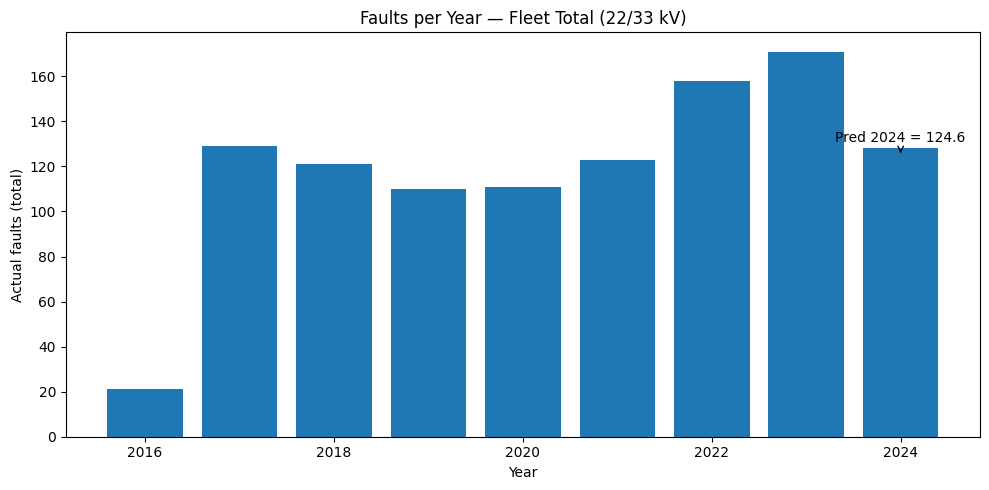

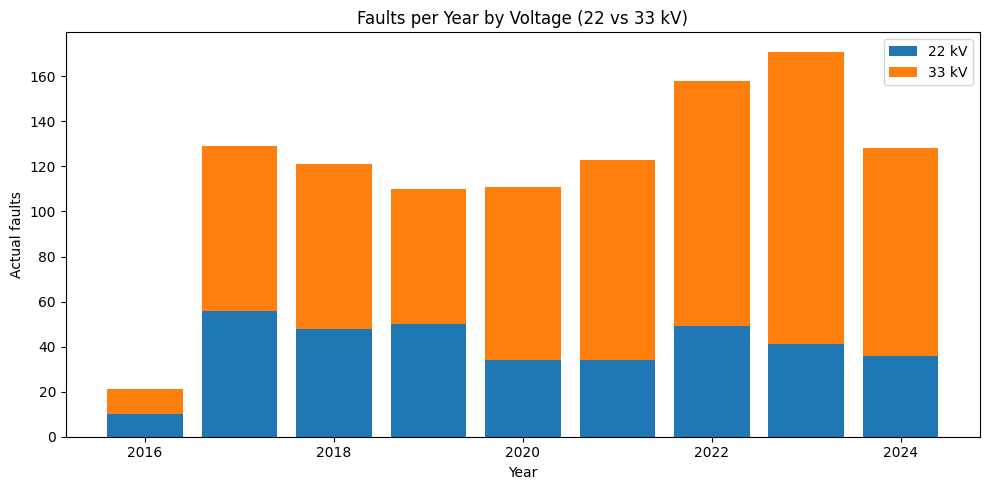

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Cell 3: Plot faults per year (all years), including 22kV vs 33kV
and overlay 2024 predicted total if available.

Outputs:
  OUT_DIR/faults_per_year.csv
  OUT_DIR/plots/faults_per_year_total.png
  OUT_DIR/plots/faults_per_year_by_voltage.png
"""

from __future__ import annotations
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ─── reuse same constants/paths ─────────────────────────────────────────
FAULT_CSV = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/DATA_GENERATION/FAULT DATA/HT_fault_cable_info_processed_without_affected.csv")
OUT_DIR   = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/A_fault_model_with_health")
MIN_YEAR, TARGET_YEAR = 2016, 2024
KEEP_VOLTAGES = {22, 33}

PLOTS = OUT_DIR / "plots"
PLOTS.mkdir(parents=True, exist_ok=True)

# ─── helpers (standalone) ───────────────────────────────────────────────
def v_to_num(v):
    try:
        return float(str(v).lower().replace("kv",""))
    except Exception:
        return math.nan

def norm_sw(s):
    return (s.astype(str).str.upper().str.strip()
             .str.replace(r"^(SWNO_|SWNO|SW|S)\s*", "", regex=True)
             .str.replace(r"\D+","",regex=True)
             .replace("", np.nan)).astype("Int64")

# ─── load & clean fault log ─────────────────────────────────────────────
fault = pd.read_csv(FAULT_CSV, parse_dates=["TIME_OUTAGE"], low_memory=False)
sw_col = "TO_SWITCH" if "TO_SWITCH" in fault.columns else fault.columns[0]
fault["SWITCH_ID"] = norm_sw(fault[sw_col])
fault = fault.dropna(subset=["SWITCH_ID","TIME_OUTAGE"])
fault = fault[fault["TIME_OUTAGE"].dt.year.between(MIN_YEAR, TARGET_YEAR)]

has_voltage = "VOLTAGE" in fault.columns
if has_voltage:
    fault["VNUM"] = fault["VOLTAGE"].apply(v_to_num)
    fault = fault[fault["VNUM"].isin(KEEP_VOLTAGES)]

# ─── group by year (+ voltage if available) ─────────────────────────────
fault["YEAR"] = fault["TIME_OUTAGE"].dt.year
years_full = pd.Index(range(MIN_YEAR, TARGET_YEAR + 1), name="YEAR")

if has_voltage:
    g = fault.groupby(["YEAR","VNUM"]).size().rename("COUNT").reset_index()
    # Pivot to columns 22 and 33; ensure both exist
    wide = g.pivot(index="YEAR", columns="VNUM", values="COUNT").reindex(years_full).fillna(0).astype(int)
    for v in (22.0, 33.0):
        if v not in wide.columns:
            wide[v] = 0
    wide = wide[[22.0, 33.0]]
    wide.columns = ["V22", "V33"]
    wide["TOTAL"] = wide["V22"] + wide["V33"]
else:
    # No voltage column; just totals
    wide = fault.groupby("YEAR").size().rename("TOTAL").reindex(years_full).fillna(0).to_frame()
    wide["V22"] = np.nan
    wide["V33"] = np.nan

# ─── bring in 2024 predicted total if available ─────────────────────────
predicted_2024 = np.nan
per_year_path = OUT_DIR / "per_switch_yearly_forecasts.csv"
if per_year_path.exists():
    try:
        per_y = pd.read_csv(per_year_path)
        predicted_2024 = float(per_y["PRED_FULL"].sum())
    except Exception:
        pass
wide["PRED_2024"] = np.nan
wide.loc[2024, "PRED_2024"] = predicted_2024

# Save tidy CSV
wide.reset_index().to_csv(OUT_DIR / "faults_per_year.csv", index=False)

# ─── Plot 1: Total faults per year (bar) + predicted 2024 marker ───────
fig1, ax1 = plt.subplots(figsize=(10, 5))
ax1.bar(wide.index, wide["TOTAL"])
ax1.set_xlabel("Year")
ax1.set_ylabel("Actual faults (total)")
ax1.set_title("Faults per Year — Fleet Total (22/33 kV)")

# Overlay predicted total for 2024 if present
if not np.isnan(predicted_2024):
    ax1.plot([2024], [predicted_2024], marker="o")
    ax1.annotate(f"Pred 2024 = {predicted_2024:.1f}",
                 xy=(2024, predicted_2024),
                 xytext=(2024, predicted_2024*1.05 if predicted_2024>0 else 5),
                 ha="center", arrowprops=dict(arrowstyle="->"))

fig1.tight_layout()
fig1.savefig(PLOTS / "faults_per_year_total.png", dpi=150)

# ─── Plot 2: 22 vs 33 kV (stacked bars) ────────────────────────────────
if has_voltage:
    fig2, ax2 = plt.subplots(figsize=(10, 5))
    ax2.bar(wide.index, wide["V22"], label="22 kV")
    ax2.bar(wide.index, wide["V33"], bottom=wide["V22"], label="33 kV")
    ax2.set_xlabel("Year")
    ax2.set_ylabel("Actual faults")
    ax2.set_title("Faults per Year by Voltage (22 vs 33 kV)")
    ax2.legend()
    fig2.tight_layout()
    fig2.savefig(PLOTS / "faults_per_year_by_voltage.png", dpi=150)

print("Saved:")
print(f"  -> {OUT_DIR/'faults_per_year.csv'}")
print(f"  ->{PLOTS/'faults_per_year_total.png'}")
if has_voltage:
    print(f"  -> {PLOTS/'faults_per_year_by_voltage.png'}")


Heaalth score with other attribute 


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
HT-cable Poisson-LSTM forecast + 9-factor health score (2018-2024)
2025-08-06 — full driver labels + weight columns
"""

from __future__ import annotations
import logging, math, sys, json, numpy as np, pandas as pd
import torch, torch.nn as nn
from pathlib import Path
from sklearn.metrics import confusion_matrix, roc_auc_score
from torch.utils.data import Dataset, DataLoader
from warnings import filterwarnings
from datetime import date
filterwarnings("ignore", category=FutureWarning)

# ─── paths ──────────────────────────────────────────────────────────────
FAULT_CSV = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/DATA_GENERATION/FAULT DATA/HT_fault_cable_info_processed_without_affected.csv")
CABLE_CSV = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/DATA_GENERATION/22_33KV CABLE FULL DATA/FINAL_22_33KV_TILL_SCADA.csv")
OUT_DIR   = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/A_fault_model_with_health")

# ─── constants / hyper-params ───────────────────────────────────────────
MIN_YEAR, TARGET_YEAR   = 2016, 2024
TRAIN_YEARS             = list(range(2018, TARGET_YEAR))
KEEP_VOLTAGES           = {22, 33}
EXPECTED_LIFE_YEARS     = 35

# 9-factor weights (p = 15 %; other eight share 85 %)
W = dict(  a= 0.01941,
  c= 0.03371,
  f= 0.12157,
  i= 0.10727,
  l= 0.25278,
  p= 0.15000,
  r= 0.04904,
  s= 0.06028,
  u= 0.20594 )   #  ←

BATCH, EPOCHS, PATIENCE = 64, 40, 12
LR, WD, CLIP            = 1e-3, 1e-5, 1.0
HID, LAY, DROP, EMB     = 512, 2, 0.1, 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42); np.random.seed(42)

logging.basicConfig(format="%(asctime)s | %(message)s",
                    datefmt="%H:%M:%S", level=logging.INFO, stream=sys.stdout)
log = logging.getLogger("pipeline").info

# ─── helper functions (unchanged) ───────────────────────────────────────
def v_to_num(v):
    try: return float(str(v).lower().replace("kv",""))
    except: return math.nan

def norm_sw(s):
    return (s.astype(str).str.upper().str.strip()
             .str.replace(r"^(SWNO_|SWNO|SW|S)\s*", "", regex=True)
             .str.replace(r"\D+","",regex=True)
             .replace("", np.nan)).astype("Int64")

def month_range(a,b): return pd.period_range(f"{a}-01", f"{b}-12", freq="M")

def sincos(idx):
    ang = 2*np.pi*idx.month.values/12
    return np.stack([np.sin(ang), np.cos(ang)], 1)

def robust(s, lo=5, hi=95):
    c=s.replace([np.inf,-np.inf],np.nan).dropna()
    if c.empty: return pd.Series(0., index=s.index)
    a,b=np.percentile(c,[lo,hi]); return ((s-a).clip(0,b-a)/(b-a+1e-9)).fillna(0.)

def months_to_quarters(mat):
    q=np.zeros((mat.shape[0],4))
    q[:,0]=mat[:,0:3].sum(1); q[:,1]=mat[:,3:6].sum(1)
    q[:,2]=mat[:,6:9].sum(1); q[:,3]=mat[:,9:12].sum(1)
    return q

# ─── 1 · fault history  (identical logic) ───────────────────────────────
fault=pd.read_csv(FAULT_CSV,parse_dates=["TIME_OUTAGE"],low_memory=False)
sw_col="TO_SWITCH" if "TO_SWITCH" in fault.columns else fault.columns[0]
fault["SWITCH_ID"]=norm_sw(fault[sw_col])
fault=fault.dropna(subset=["SWITCH_ID","TIME_OUTAGE"])
fault=fault[fault["TIME_OUTAGE"].dt.year.between(MIN_YEAR,TARGET_YEAR)]
if "VOLTAGE" in fault.columns:
    fault["VNUM"]=fault["VOLTAGE"].apply(v_to_num)
    fault=fault[fault["VNUM"].isin(KEEP_VOLTAGES)]
fault=fault.drop_duplicates(["SWITCH_ID","TIME_OUTAGE"])
fault["YM"]=fault["TIME_OUTAGE"].dt.to_period("M")

idx_full=month_range(MIN_YEAR,TARGET_YEAR)
counts=(fault[fault["TIME_OUTAGE"].dt.year<=TARGET_YEAR-1]
        .groupby(["SWITCH_ID","YM"]).size()
        .unstack(fill_value=0)
        .reindex(columns=idx_full,fill_value=0).astype(float))
switches=counts.index.tolist(); sw2idx={sw:i for i,sw in enumerate(switches)}

# ─── 2 · Poisson-LSTM dataset & training  (unchanged) ───────────────────
class WinDS(Dataset):
    def __init__(self, fr):
        self.x  = torch.tensor(fr["X_seq"],dtype=torch.float32)
        self.xs = torch.tensor(fr["X_season"],dtype=torch.float32)
        self.y  = torch.tensor(fr["y_seq"],dtype=torch.float32)
        self.sw = torch.tensor(fr["sw_idx"],dtype=torch.long)
    def __len__(self): return len(self.sw)
    def __getitem__(self,i): return self.x[i],self.xs[i],self.y[i],self.sw[i]

class PoissonLSTM(nn.Module):
    def __init__(self,n_sw):
        super().__init__()
        self.emb = nn.Embedding(n_sw, EMB)
        self.rnn = nn.LSTM(3,HID,LAY,batch_first=True,
                           dropout=DROP if LAY>1 else 0.)
        self.head=nn.Sequential(nn.Linear(HID+EMB,HID),nn.ReLU(),
                                nn.Linear(HID,HID//2),nn.ReLU(),
                                nn.Linear(HID//2,12))
        self.sp = nn.Softplus()
    def forward(self,x,xs,sw):
        h,_=self.rnn(torch.cat([x,xs],-1))
        h=torch.cat([h[:,-1],self.emb(sw)],1)
        return self.sp(self.head(h))

def build_frames(years, nonzero=True):
    X_seq,X_sea,y_seq,sw_idx=[],[],[],[]
    for sw,row in counts.iterrows():
        for Y in years:
            tr,tg=month_range(Y-2,Y-1),month_range(Y,Y)
            if nonzero and row[tr].sum()==0: continue
            X_seq.append(np.log1p(row[tr]).values[:,None])
            X_sea.append(sincos(tr)); y_seq.append(row[tg].values)
            sw_idx.append(sw2idx[sw])
    return dict(X_seq=np.stack(X_seq),
                X_season=np.stack(X_sea),
                y_seq=np.stack(y_seq),
                sw_idx=np.array(sw_idx,dtype=np.int64))

train_frames=build_frames(TRAIN_YEARS,True)
ds=WinDS(train_frames); perm=np.random.permutation(len(ds))
n_val=max(1,int(.1*len(ds)))
dl_tr=DataLoader(torch.utils.data.Subset(ds,perm[:-n_val]),BATCH,shuffle=True)
dl_va=DataLoader(torch.utils.data.Subset(ds,perm[-n_val:]),BATCH,shuffle=False)

model=PoissonLSTM(len(switches)).to(DEVICE)
loss_fn,opt=nn.PoissonNLLLoss(log_input=False),torch.optim.Adam(model.parameters(),lr=LR,weight_decay=WD)

best,bad,best_ep=1e9,0,0
for ep in range(1,EPOCHS+1):
    model.train()
    for xb,xs,yb,swb in dl_tr:
        xb,xs,yb,swb=[t.to(DEVICE) for t in (xb,xs,yb,swb)]
        opt.zero_grad(); loss_fn(model(xb,xs,swb),yb).backward()
        nn.utils.clip_grad_norm_(model.parameters(),CLIP); opt.step()
    with torch.no_grad():
        v=np.mean([loss_fn(model(x.to(DEVICE),xs.to(DEVICE),sw.to(DEVICE)),
                           y.to(DEVICE)).item()
                   for x,xs,y,sw in dl_va])
    if v<best-1e-4: best,bad,best_ep,ckpt=v,0,ep,model.state_dict()
    else: bad+=1
    if bad>=PATIENCE: break
model.load_state_dict(ckpt)
log(f"Training finished in {best_ep} epochs | best val-loss={best:.4f}")

# ─── 3 · 2024 forecasts  (unchanged) ────────────────────────────────────
eval_frames=build_frames([TARGET_YEAR],False)
mu,swids=[],[]
with torch.no_grad():
    for xb,xs,_,swb in DataLoader(WinDS(eval_frames),256,False):
        xb,xs,swb=[t.to(DEVICE) for t in (xb,xs,swb)]
        mu.append(model(xb,xs,swb).cpu().numpy())
        swids.append(swb.cpu().numpy())
MU,SWIDX=np.concatenate(mu),np.concatenate(swids)
QTRS=months_to_quarters(MU)

ym=month_range(TARGET_YEAR,TARGET_YEAR)
rows_m,rows_q,rows_y=[],[],[]
for i,ix in enumerate(SWIDX):
    sw=switches[ix]
    rows_y.append(dict(SWITCH_ID=sw,YEAR=TARGET_YEAR,PRED_FULL=float(MU[i].sum())))
    for m in range(12):
        rows_m.append(dict(SWITCH_ID=sw,YEAR=TARGET_YEAR,MONTH=m+1,
                           YM=str(ym[m]),PRED_FAULTS=float(MU[i,m])))
    for qi,qsum in enumerate(QTRS[i],1):
        rows_q.append(dict(SWITCH_ID=sw,YEAR=TARGET_YEAR,QUARTER=qi,
                           PRED_FAULTS_Q=float(qsum)))

OUT_DIR.mkdir(parents=True,exist_ok=True)
pd.DataFrame(rows_m).to_csv(OUT_DIR/"per_switch_monthly_forecasts.csv",index=False)
pd.DataFrame(rows_q).to_csv(OUT_DIR/"per_switch_quarterly_forecasts.csv",index=False)
per_y=pd.DataFrame(rows_y)
per_y.to_csv(OUT_DIR/"per_switch_yearly_forecasts.csv",index=False)

# ─── 4 · health score (9 factors) ───────────────────────────────────────
cables=pd.read_csv(CABLE_CSV, low_memory=False).drop_duplicates("DESTINATION_SWITCH_ID")
today=pd.Timestamp.utcnow().tz_localize(None)

cab=cables.rename(columns={"DESTINATION_SWITCH_ID":"SWITCH_ID",
                           "MEASUREDLENGTH":"LENGTH_M",
                           "COMMISSIONEDDATE":"DATE_INSTALLED",
                           "NO_OF_SEGMENT":"SEGMENTS"})
cab["LENGTH_KM"]=pd.to_numeric(cab["LENGTH_M"],errors="coerce")/1000
cab["DATE_INSTALLED"]=(pd.to_datetime(cab["DATE_INSTALLED"],errors="coerce",utc=True)
                       .dt.tz_localize(None))
cyc=[c for c in cab.columns if c.startswith("CYCLE_Month_")]
var=[c for c in cab.columns if c.startswith("VAR_Month_")]
cab["cycle_pm"]=cab[cyc].mean(1)
cab["load_range_idx"]=cab[var].mean(1)/cab[var].median(1)

hist=fault[fault["TIME_OUTAGE"].dt.year<=TARGET_YEAR-1] \
        .groupby("SWITCH_ID").size()
cab=cab.merge(hist.rename("hist_faults"),on="SWITCH_ID",how="left").fillna({"hist_faults":0})
cab=cab.merge(per_y.rename(columns={"PRED_FULL":"pred_faults_2024"}),
              on="SWITCH_ID",how="left").fillna({"pred_faults_2024":0})

fault_sorted=fault.sort_values(["SWITCH_ID","TIME_OUTAGE"])
fault_sorted["Δt_h"]=(fault_sorted.groupby("SWITCH_ID")["TIME_OUTAGE"]
                      .diff().dt.total_seconds().div(3600))
mean_dt=fault_sorted.groupby("SWITCH_ID")["Δt_h"].mean().rename("mean_h")
cab=cab.merge(mean_dt,on="SWITCH_ID",how="left")

recent_cut=(pd.Timestamp(f"{TARGET_YEAR}-01-01", tz="UTC") - pd.DateOffset(months=8))
recent_cnt=(fault[fault["TIME_OUTAGE"]>=recent_cut].groupby("SWITCH_ID").size())
cab=cab.merge(recent_cnt.rename("recent8"),on="SWITCH_ID",how="left").fillna({"recent8":0})

cab["DATE_INSTALLED"] = pd.to_datetime(cab["DATE_INSTALLED"])

# Get today's date and convert it to a pandas Timestamp
today = pd.Timestamp(date.today())

# Calculate the difference in days using the full dates
time_elapsed = today - cab["DATE_INSTALLED"]
days_elapsed = time_elapsed.dt.days

# Define the total expected days
expected_total_days = EXPECTED_LIFE_YEARS * 365

# Calculate the new 'a_raw' column
cab["a_raw"] = days_elapsed / expected_total_days

cab["c_raw"]=cab["cycle_pm"]
cab["r_raw"]=cab["load_range_idx"]
cab["f_raw"]=cab["hist_faults"]/cab["LENGTH_KM"].replace(0,np.nan)
cab["s_raw"]=(cab["SEGMENTS"].fillna(1)).clip(lower=0)
cab["p_raw"]=cab["pred_faults_2024"].replace(0,np.nan)
cab["i_raw"]=1/cab["mean_h"].clip(lower=1)
cab["l_raw"]=np.log1p(cab["LENGTH_KM"])    # length factor
cab["u_raw"]=cab["recent8"]

for col in ["c_raw","r_raw","a_raw","f_raw","s_raw","p_raw",
            "i_raw","l_raw","u_raw"]:
    cab[col[0]]=robust(cab[col])

# risk & score
risk=sum(W[k]*cab[k] for k in W.keys())
cab["health_score"]=np.rint(100*(1-risk)).clip(0,100).astype(int)
cab["health_score_10"]=np.clip(np.ceil(cab["health_score"]/10),1,10).astype(int)
cab["health_band"]=pd.cut(cab["health_score"],[-np.inf,40,60,100],
                          labels=["Poor","Moderate","Good"])

# # add constant weight columns
# for k,wv in W.items():
#     cab[f"weight_{k}"] = wv

# driver labels
LABELS = {
    "c":"High cyclic loading (c)",
    "r":"Wide load-range utilisation (r)",
    "a":"Advanced cable age (a)",
    "f":"Many historic faults (f)",
    "s":"Numerous joints / segments (s)",
    "p":"High predicted faults per km (p)",
    "i":"Frequent interruptions (i)",
    "l":"Long circuit length (ℓ)",
    "u":"Recent-8-month faults(u)"
}
risk_contrib=pd.DataFrame({k:W[k]*cab[k] for k in W.keys()})
top3=risk_contrib.apply(lambda r:r.nlargest(3).index.tolist(),axis=1)
cab["primary_health_driver"]=top3.apply(lambda lst: LABELS[lst[0]])
cab["top3_health_drivers"]=top3.apply(lambda lst: "; ".join(LABELS[k] for k in lst))

mask_nofault=(cab["hist_faults"].eq(0)&cab["recent8"].eq(0))
cab.loc[mask_nofault,["health_score","health_score_10"]]=[100,10]
cab.loc[mask_nofault,"health_band"]="Good"
cab.loc[mask_nofault,"primary_health_driver"]="No recorded faults"
cab.loc[mask_nofault,"top3_health_drivers"]="No recorded faults"

# save CSVs
# The 'pred_faults_2024' column is already in the 'cab' DataFrame and will be saved.
cab.to_csv(OUT_DIR/"cable_health_2024_scored.csv",index=False)

predict_mask=~mask_nofault
cab_pred=cab[predict_mask]
cab_pred.to_csv(OUT_DIR/"cable_health_2024_predictions.csv",index=False)
log(f"Saved predictions for {len(cab_pred)} cables -> cable_health_2024_predictions.csv")

# ─── ADDED CODE STARTS HERE ─────────────────────────────────────────────
# Calculate total predicted and actual faults for the target year
total_predicted_faults = per_y['PRED_FULL'].sum()
total_actual_faults_2024 = fault[fault['TIME_OUTAGE'].dt.year == TARGET_YEAR].shape[0]

log("\n" + "="*40)
log(f"FLEET-WIDE FAULT SUMMARY FOR YEAR {TARGET_YEAR}")
log("="*40)
log(f"Total Predicted Faults: {total_predicted_faults:.1f}")
log(f"Total Actual Faults:    {total_actual_faults_2024}")
log("="*40 + "\n")
# ─── ADDED CODE ENDS HERE ───────────────────────────────────────────────

# validation
actual=fault[fault["TIME_OUTAGE"].dt.year==TARGET_YEAR]["SWITCH_ID"].unique()
cab["ACTUAL_FAIL_24"]=cab["SWITCH_ID"].isin(actual).astype(int)
pred=cab["health_band"].map({"Poor":1,"Moderate":1,"Good":0})
cm=confusion_matrix(cab["ACTUAL_FAIL_24"],pred)
au=roc_auc_score(cab["ACTUAL_FAIL_24"],100-cab["health_score"])
log(f"2024 confusion matrix:\n{cm}\nAUROC = {au:.3f}")
log("Factor weights applied: "+json.dumps(W))
log("Pipeline complete → %s", OUT_DIR.resolve())

/tmp/ipykernel_14152/1196138432.py:88: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  fault["YM"]=fault["TIME_OUTAGE"].dt.to_period("M")


21:52:25 | Training finished in 4 epochs | best val-loss=0.1891
21:52:25 | Saved predictions for 190 cables -> cable_health_2024_predictions.csv
21:52:25 | 
21:52:25 | FLEET-WIDE FAULT SUMMARY FOR YEAR 2024
21:52:25 | ========================================
21:52:25 | Total Predicted Faults: 124.6
21:52:25 | Total Actual Faults:    128
21:52:25 | ========================================

21:52:25 | 2024 confusion matrix:
[[148  36]
 [ 14  58]]
AUROC = 0.881
21:52:25 | Factor weights applied: {"a": 0.01941, "c": 0.03371, "f": 0.12157, "i": 0.10727, "l": 0.25278, "p": 0.15, "r": 0.04904, "s": 0.06028, "u": 0.20594}
21:52:25 | Pipeline complete → /media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/A_fault_model_with_health


In [18]:
df = pd.read_csv(OUT_DIR/"cable_health_2024_scored.csv")

In [19]:
print(len(df['SWITCH_ID']), "unique SWITCH_IDs in the final health score CSV.")

256 unique SWITCH_IDs in the final health score CSV.


aagregate lentght duplicae switches and removing discconected and abondede file 



In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
HT-cable Poisson-LSTM forecast + 9-factor health score (2018-2024)
2025-08-06 — full driver labels + weight columns
MODIFIED: 2025-08-18 - Added logic for remark-based filtering and duplicate aggregation.
"""

from __future__ import annotations
import logging, math, sys, json, numpy as np, pandas as pd
import torch, torch.nn as nn
from pathlib import Path
from sklearn.metrics import confusion_matrix, roc_auc_score
from torch.utils.data import Dataset, DataLoader
from warnings import filterwarnings
filterwarnings("ignore", category=FutureWarning)

# ─── paths ──────────────────────────────────────────────────────────────
FAULT_CSV = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/DATA_GENERATION/FAULT DATA/HT_fault_cable_info_processed_with_affected.csv")
CABLE_CSV = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/DATA_GENERATION/SWNO_MASTER_COMBINED_FULL_FINAL4.csv")
OUT_DIR   = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/A_fault_model_with_health")

# ─── constants / hyper-params ───────────────────────────────────────────
MIN_YEAR, TARGET_YEAR   = 2016, 2024
TRAIN_YEARS             = list(range(2018, TARGET_YEAR))
KEEP_VOLTAGES           = {22, 33}
EXPECTED_LIFE_YEARS     = 35

# 9-factor weights (p = 15 %; other eight share 85 %)
W = dict(  a= 0.01941,
  c= 0.03371,
  f= 0.12157,
  i= 0.10727,
  l= 0.25278,
  p= 0.15000,
  r= 0.04904,
  s= 0.06028,
  u= 0.20594 )

BATCH, EPOCHS, PATIENCE = 64, 40, 12
LR, WD, CLIP            = 1e-3, 1e-5, 1.0
HID, LAY, DROP, EMB     = 512, 2, 0.1, 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42); np.random.seed(42)

logging.basicConfig(format="%(asctime)s | %(message)s",
                    datefmt="%H:%M:%S", level=logging.INFO, stream=sys.stdout)
log = logging.getLogger("pipeline").info

# ─── helper functions (unchanged) ───────────────────────────────────────
def v_to_num(v):
    try: return float(str(v).lower().replace("kv",""))
    except: return math.nan

def norm_sw(s):
    return (s.astype(str).str.upper().str.strip()
             .str.replace(r"^(SWNO_|SWNO|SW|S)\s*", "", regex=True)
             .str.replace(r"\D+","",regex=True)
             .replace("", np.nan)).astype("Int64")

def month_range(a,b): return pd.period_range(f"{a}-01", f"{b}-12", freq="M")

def sincos(idx):
    ang = 2*np.pi*idx.month.values/12
    return np.stack([np.sin(ang), np.cos(ang)], 1)

def robust(s, lo=5, hi=95):
    c=s.replace([np.inf,-np.inf],np.nan).dropna()
    if c.empty: return pd.Series(0., index=s.index)
    a,b=np.percentile(c,[lo,hi]); return ((s-a).clip(0,b-a)/(b-a+1e-9)).fillna(0.)

def months_to_quarters(mat):
    q=np.zeros((mat.shape[0],4))
    q[:,0]=mat[:,0:3].sum(1); q[:,1]=mat[:,3:6].sum(1)
    q[:,2]=mat[:,6:9].sum(1); q[:,3]=mat[:,9:12].sum(1)
    return q

# ─── 1 · fault history  (identical logic) ───────────────────────────────
fault=pd.read_csv(FAULT_CSV,parse_dates=["TIME_OUTAGE"],low_memory=False)
sw_col="TO_SWITCH" if "TO_SWITCH" in fault.columns else fault.columns[0]
fault["SWITCH_ID"]=norm_sw(fault[sw_col])
fault=fault.dropna(subset=["SWITCH_ID","TIME_OUTAGE"])
fault=fault[fault["TIME_OUTAGE"].dt.year.between(MIN_YEAR,TARGET_YEAR)]
if "VOLTAGE" in fault.columns:
    fault["VNUM"]=fault["VOLTAGE"].apply(v_to_num)
    fault=fault[fault["VNUM"].isin(KEEP_VOLTAGES)]
fault=fault.drop_duplicates(["SWITCH_ID","TIME_OUTAGE"])
fault["YM"]=fault["TIME_OUTAGE"].dt.to_period("M")

idx_full=month_range(MIN_YEAR,TARGET_YEAR)
counts=(fault[fault["TIME_OUTAGE"].dt.year<=TARGET_YEAR-1]
        .groupby(["SWITCH_ID","YM"]).size()
        .unstack(fill_value=0)
        .reindex(columns=idx_full,fill_value=0).astype(float))
switches=counts.index.tolist(); sw2idx={sw:i for i,sw in enumerate(switches)}

# ─── 2 · Poisson-LSTM dataset & training  (unchanged) ───────────────────
class WinDS(Dataset):
    def __init__(self, fr):
        self.x  = torch.tensor(fr["X_seq"],dtype=torch.float32)
        self.xs = torch.tensor(fr["X_season"],dtype=torch.float32)
        self.y  = torch.tensor(fr["y_seq"],dtype=torch.float32)
        self.sw = torch.tensor(fr["sw_idx"],dtype=torch.long)
    def __len__(self): return len(self.sw)
    def __getitem__(self,i): return self.x[i],self.xs[i],self.y[i],self.sw[i]

class PoissonLSTM(nn.Module):
    def __init__(self,n_sw):
        super().__init__()
        self.emb = nn.Embedding(n_sw, EMB)
        self.rnn = nn.LSTM(3,HID,LAY,batch_first=True,
                           dropout=DROP if LAY>1 else 0.)
        self.head=nn.Sequential(nn.Linear(HID+EMB,HID),nn.ReLU(),
                                nn.Linear(HID,HID//2),nn.ReLU(),
                                nn.Linear(HID//2,12))
        self.sp = nn.Softplus()
    def forward(self,x,xs,sw):
        h,_=self.rnn(torch.cat([x,xs],-1))
        h=torch.cat([h[:,-1],self.emb(sw)],1)
        return self.sp(self.head(h))

def build_frames(years, nonzero=True):
    X_seq,X_sea,y_seq,sw_idx=[],[],[],[]
    for sw,row in counts.iterrows():
        for Y in years:
            tr,tg=month_range(Y-2,Y-1),month_range(Y,Y)
            if nonzero and row[tr].sum()==0: continue
            X_seq.append(np.log1p(row[tr]).values[:,None])
            X_sea.append(sincos(tr)); y_seq.append(row[tg].values)
            sw_idx.append(sw2idx[sw])
    return dict(X_seq=np.stack(X_seq),
                X_season=np.stack(X_sea),
                y_seq=np.stack(y_seq),
                sw_idx=np.array(sw_idx,dtype=np.int64))

train_frames=build_frames(TRAIN_YEARS,True)
ds=WinDS(train_frames); perm=np.random.permutation(len(ds))
n_val=max(1,int(.1*len(ds)))
dl_tr=DataLoader(torch.utils.data.Subset(ds,perm[:-n_val]),BATCH,shuffle=True)
dl_va=DataLoader(torch.utils.data.Subset(ds,perm[-n_val:]),BATCH,shuffle=False)

model=PoissonLSTM(len(switches)).to(DEVICE)
loss_fn,opt=nn.PoissonNLLLoss(log_input=False),torch.optim.Adam(model.parameters(),lr=LR,weight_decay=WD)

best,bad,best_ep=1e15,0,0
for ep in range(1,EPOCHS+1):
    model.train()
    for xb,xs,yb,swb in dl_tr:
        xb,xs,yb,swb=[t.to(DEVICE) for t in (xb,xs,yb,swb)]
        opt.zero_grad(); loss_fn(model(xb,xs,swb),yb).backward()
        nn.utils.clip_grad_norm_(model.parameters(),CLIP); opt.step()
    with torch.no_grad():
        v=np.mean([loss_fn(model(x.to(DEVICE),xs.to(DEVICE),sw.to(DEVICE)),
                           y.to(DEVICE)).item()
                   for x,xs,y,sw in dl_va])
    if v<best-1e-4: best,bad,best_ep,ckpt=v,0,ep,model.state_dict()
    else: bad+=1
    if bad>=PATIENCE: break
model.load_state_dict(ckpt)
log(f"Training finished in {best_ep} epochs | best val-loss={best:.4f}")

# ─── 3 · 2024 forecasts  (unchanged) ────────────────────────────────────
eval_frames=build_frames([TARGET_YEAR],False)
mu,swids=[],[]
with torch.no_grad():
    for xb,xs,_,swb in DataLoader(WinDS(eval_frames),256,False):
        xb,xs,swb=[t.to(DEVICE) for t in (xb,xs,swb)]
        mu.append(model(xb,xs,swb).cpu().numpy())
        swids.append(swb.cpu().numpy())
MU,SWIDX=np.concatenate(mu),np.concatenate(swids)
QTRS=months_to_quarters(MU)

ym=month_range(TARGET_YEAR,TARGET_YEAR)
rows_m,rows_q,rows_y=[],[],[]
for i,ix in enumerate(SWIDX):
    sw=switches[ix]
    rows_y.append(dict(SWITCH_ID=sw,YEAR=TARGET_YEAR,PRED_FULL=float(MU[i].sum())))
    for m in range(12):
        rows_m.append(dict(SWITCH_ID=sw,YEAR=TARGET_YEAR,MONTH=m+1,
                           YM=str(ym[m]),PRED_FAULTS=float(MU[i,m])))
    for qi,qsum in enumerate(QTRS[i],1):
        rows_q.append(dict(SWITCH_ID=sw,YEAR=TARGET_YEAR,QUARTER=qi,
                           PRED_FAULTS_Q=float(qsum)))

OUT_DIR.mkdir(parents=True,exist_ok=True)
pd.DataFrame(rows_m).to_csv(OUT_DIR/"per_switch_monthly_forecasts.csv",index=False)
pd.DataFrame(rows_q).to_csv(OUT_DIR/"per_switch_quarterly_forecasts.csv",index=False)
per_y=pd.DataFrame(rows_y)
per_y.to_csv(OUT_DIR/"per_switch_yearly_forecasts.csv",index=False)

# ─── 4 · health score (9 factors) ───────────────────────────────────────
# OLD LINE: cables=pd.read_csv(CABLE_CSV, low_memory=False).drop_duplicates("DESTINATION_SWITCH_ID")

# --- NEW LOGIC START ---
log("Loading and processing cable master data...")
cables_raw = pd.read_csv(CABLE_CSV, low_memory=False)

# 1. Filter out rows based on remarks (case-insensitive)
# Assuming the column is named 'REMARKS'. If not, change the name here.
REMARK_COL = 'REMARKS' 
if REMARK_COL in cables_raw.columns:
    log(f"Filtering rows based on keywords in '{REMARK_COL}' column.")
    # Ensure the column is string type and handle NaNs
    remarks_lower = cables_raw[REMARK_COL].str.lower().fillna('')
    # Keywords to identify rows for removal
    keywords = 'disconnected|abandoned'
    mask_to_remove = remarks_lower.str.contains(keywords, regex=True)
    cables_filtered = cables_raw[~mask_to_remove].copy()
    log(f"Removed {mask_to_remove.sum()} rows. {len(cables_filtered)} rows remain.")
# else:
#     log(f"Warning: Column '{REMARK_COL}' not found. Skipping remark-based filtering.")
#     cables_filtered = cables_raw.copy()

print(f"Initial cable count: {len(cables_filtered)} unique cables.")


# 2. Aggregate remaining duplicates by summing length
log("Aggregating duplicates for 'DESTINATION_SWITCH_ID'.")
# Ensure 'MEASUREDLENGTH' is numeric, coercing errors to NaN (which sum to 0)
cables_filtered['MEASUREDLENGTH'] = pd.to_numeric(cables_filtered['MEASUREDLENGTH'], errors='coerce')
# Define aggregation rules: sum length, take the first value for all other columns
agg_rules = {col: 'first' for col in cables_filtered.columns if col != 'DESTINATION_SWITCH_ID'}
agg_rules['MEASUREDLENGTH'] = 'sum'

cables = cables_filtered.groupby('DESTINATION_SWITCH_ID', as_index=False).agg(agg_rules)
log(f"Final cable count after aggregation: {len(cables)} unique switches.")
# --- NEW LOGIC END ---


today=pd.Timestamp.utcnow().tz_localize(None)

cab=cables.rename(columns={"DESTINATION_SWITCH_ID":"SWITCH_ID",
                           "MEASUREDLENGTH":"LENGTH_M",
                           "COMMISSIONEDDATE":"DATE_INSTALLED",
                           "NO_OF_SEGMENT":"SEGMENTS"})
cab["LENGTH_KM"]=pd.to_numeric(cab["LENGTH_M"],errors="coerce")/1000
cab["DATE_INSTALLED"]=(pd.to_datetime(cab["DATE_INSTALLED"],errors="coerce",utc=True)
                       .dt.tz_localize(None))
cyc=[c for c in cab.columns if c.startswith("CYCLE_Month_")]
var=[c for c in cab.columns if c.startswith("VAR_Month_")]
cab["cycle_pm"]=cab[cyc].mean(1)
cab["load_range_idx"]=cab[var].mean(1)/cab[var].median(1)

hist=fault[fault["TIME_OUTAGE"].dt.year<=TARGET_YEAR-1] \
        .groupby("SWITCH_ID").size()
cab=cab.merge(hist.rename("hist_faults"),on="SWITCH_ID",how="left").fillna({"hist_faults":0})
cab=cab.merge(per_y.rename(columns={"PRED_FULL":"pred_faults_2024"}),
              on="SWITCH_ID",how="left").fillna({"pred_faults_2024":0})

fault_sorted=fault.sort_values(["SWITCH_ID","TIME_OUTAGE"])
fault_sorted["Δt_h"]=(fault_sorted.groupby("SWITCH_ID")["TIME_OUTAGE"]
                      .diff().dt.total_seconds().div(3600))
mean_dt=fault_sorted.groupby("SWITCH_ID")["Δt_h"].mean().rename("mean_h")
cab=cab.merge(mean_dt,on="SWITCH_ID",how="left")

recent_cut=(pd.Timestamp(f"{TARGET_YEAR}-01-01", tz="UTC") - pd.DateOffset(months=8))
recent_cnt=(fault[fault["TIME_OUTAGE"]>=recent_cut].groupby("SWITCH_ID").size())
cab=cab.merge(recent_cnt.rename("recent8"),on="SWITCH_ID",how="left").fillna({"recent8":0})

cab["a_raw"]=(today.day - cab["DATE_INSTALLED"].dt.day) / (EXPECTED_LIFE_YEARS * 365)
cab["c_raw"]=cab["cycle_pm"]
cab["r_raw"]=cab["load_range_idx"]
cab["f_raw"]=cab["hist_faults"]/cab["LENGTH_KM"].replace(0,np.nan)
cab["s_raw"]=(cab["SEGMENTS"].fillna(1)-1).clip(lower=0)
cab["p_raw"]=cab["pred_faults_2024"].replace(0,np.nan)
cab["i_raw"]=1/cab["mean_h"].clip(lower=1)
cab["l_raw"]=np.log1p(cab["LENGTH_KM"])
cab["u_raw"]=cab["recent8"]

for col in ["c_raw","r_raw","a_raw","f_raw","s_raw","p_raw",
            "i_raw","l_raw","u_raw"]:
    cab[col[0]]=robust(cab[col])

# risk & score
risk=sum(W[k]*cab[k] for k in W.keys())
cab["health_score"]=np.rint(100*(1-risk)).clip(0,100).astype(int)
cab["health_score_10"]=np.clip(np.ceil(cab["health_score"]/10),1,10).astype(int)
cab["health_band"]=pd.cut(cab["health_score"],[-np.inf,40,60,100],
                          labels=["Poor","Moderate","Good"])

# add constant weight columns
for k,wv in W.items():
    cab[f"weight_{k}"] = wv

# driver labels
LABELS = {
    "c":"High cyclic loading (c)",
    "r":"Wide load-range utilisation (r)",
    "a":"Advanced cable age (a)",
    "f":"Many historic faults (f)",
    "s":"Numerous joints / segments (s)",
    "p":"High predicted faults per km (p)",
    "i":"Frequent interruptions (i)",
    "l":"Long circuit length (ℓ)",
    "u":"Recent-8-month faults(u)"
}
risk_contrib=pd.DataFrame({k:W[k]*cab[k] for k in W.keys()})
top3=risk_contrib.apply(lambda r:r.nlargest(3).index.tolist(),axis=1)
cab["primary_health_driver"]=top3.apply(lambda lst: LABELS[lst[0]])
cab["top3_health_drivers"]=top3.apply(lambda lst: "; ".join(LABELS[k] for k in lst))

mask_nofault=(cab["hist_faults"].eq(0)&cab["recent8"].eq(0))
cab.loc[mask_nofault,["health_score","health_score_10"]]=[100,10]
cab.loc[mask_nofault,"health_band"]="Good"
cab.loc[mask_nofault,"primary_health_driver"]="No recorded faults"
cab.loc[mask_nofault,"top3_health_drivers"]="No recorded faults"

# save CSVs
cab.to_csv(OUT_DIR/"cable_health_2024_scored.csv",index=False)

predict_mask=~mask_nofault
cab_pred=cab[predict_mask]
cab_pred.to_csv(OUT_DIR/"cable_health_2024_predictions.csv",index=False)
log(f"Saved predictions for {len(cab_pred)} cables -> cable_health_2024_predictions.csv")

# ─── ADDED CODE STARTS HERE ─────────────────────────────────────────────
# Calculate total predicted and actual faults for the target year
total_predicted_faults = per_y['PRED_FULL'].sum()
total_actual_faults_2024 = fault[fault['TIME_OUTAGE'].dt.year == TARGET_YEAR].shape[0]

log("\n" + "="*40)
log(f"FLEET-WIDE FAULT SUMMARY FOR YEAR {TARGET_YEAR}")
log("="*40)
log(f"Total Predicted Faults: {total_predicted_faults:.1f}")
log(f"Total Actual Faults:    {total_actual_faults_2024}")
log("="*40 + "\n")
# ─── ADDED CODE ENDS HERE ───────────────────────────────────────────────

# validation
actual=fault[fault["TIME_OUTAGE"].dt.year==TARGET_YEAR]["SWITCH_ID"].unique()
cab["ACTUAL_FAIL_24"]=cab["SWITCH_ID"].isin(actual).astype(int)
pred=cab["health_band"].map({"Poor":1,"Moderate":1,"Good":0})
cm=confusion_matrix(cab["ACTUAL_FAIL_24"],pred)
au=roc_auc_score(cab["ACTUAL_FAIL_24"],100-cab["health_score"])
log(f"2024 confusion matrix:\n{cm}\nAUROC = {au:.3f}")
# log("Factor weights applied: "+json.dumps(W))
log("Pipeline complete -> %s", OUT_DIR.resolve())

/tmp/ipykernel_621860/240735974.py:88: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  fault["YM"]=fault["TIME_OUTAGE"].dt.to_period("M")


00:15:25 | Training finished in 8 epochs | best val-loss=0.1857
00:15:26 | Loading and processing cable master data...
00:15:26 | Filtering rows based on keywords in 'REMARKS' column.
00:15:26 | Removed 26 rows. 292 rows remain.
Initial cable count: 292 unique cables.
00:15:26 | Aggregating duplicates for 'DESTINATION_SWITCH_ID'.
00:15:26 | Final cable count after aggregation: 248 unique switches.
00:15:26 | Saved predictions for 183 cables -> cable_health_2024_predictions.csv
00:15:26 | 
00:15:26 | FLEET-WIDE FAULT SUMMARY FOR YEAR 2024
00:15:26 | ========================================
00:15:26 | Total Predicted Faults: 165.0
00:15:26 | Total Actual Faults:    128
00:15:26 | ========================================

00:15:26 | 2024 confusion matrix:
[[143  34]
 [ 14  57]]
AUROC = 0.883
00:15:26 | Pipeline complete -> /media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/A_fault_model_with_health


In [15]:
file = pd.read_csv(Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/DATA_GENERATION/SWNO_MASTER_COMBINED_FULL_FINAL4.csv"))
col = file['DESTINATION_SWITCH_ID'].unique()
print(len(col), "unique SWITCH_IDs in the final health score CSV.")

256 unique SWITCH_IDs in the final health score CSV.


In [14]:
file_out = pd.read_csv(OUT_DIR/"cable_health_2024_scored.csv")
print(len(file_out['SWITCH_ID'].unique()), "unique SWITCH_IDs in the final health score CSV.")

248 unique SWITCH_IDs in the final health score CSV.


In [ ]:
import pandas as pd
from datetime import date

# Assuming 'cab' is your DataFrame
# Make sure the 'DATE_INSTALLED' column is a proper datetime object
cab["DATE_INSTALLED"] = pd.to_datetime(cab["DATE_INSTALLED"])

# Get today's date and convert it to a pandas Timestamp
today = pd.Timestamp(date.today())

# Calculate the difference in days using the full dates
time_elapsed = today - cab["DATE_INSTALLED"]
days_elapsed = time_elapsed.dt.days

# Define the total expected days
expected_total_days = EXPECTED_LIFE_YEARS * 365

# Calculate the new 'a_raw' column
cab["a_raw"] = days_elapsed / expected_total_days


In [18]:
import pandas as pd
import numpy as np
from datetime import date, timedelta

# Define the number of years for expected life
EXPECTED_LIFE_YEARS = 35

# Define a reasonable range for installation dates (e.g., last 3 years)

# Simulate a DataFrame named 'cab' with a randomly generated 'DATE_INSTALLED' column
cab = pd.DataFrame({'DATE_INSTALLED': ['2022-01-01']})
print("Randomly generated DATE_INSTALLED:", cab['DATE_INSTALLED'].iloc[0])
# Ensure 'DATE_INSTALLED' is a datetime type
cab['DATE_INSTALLED'] = pd.to_datetime(cab['DATE_INSTALLED'])

# Get today's date (as a pandas Timestamp for easier comparison)
today = pd.Timestamp(date.today())

# Calculate the difference in days
days_since_installation = (today - cab['DATE_INSTALLED']).dt.days
print("Days since installation:", days_since_installation.iloc[0])
# Calculate the total expected days
total_expected_days = EXPECTED_LIFE_YEARS * 365

# Calculate the 'a_raw' column
cab["a_raw"] = days_since_installation / total_expected_days

# Print the DataFrame to see the output
print(cab)


Randomly generated DATE_INSTALLED: 2022-01-01
Days since installation: 1346
  DATE_INSTALLED     a_raw
0     2022-01-01  0.105362
